In [5]:
!pip install seaborn

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [72]:
data = pd.read_csv('coin_Bitcoin.csv', parse_dates=['Date'], index_col='Date')

In [73]:
data.head()

,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30 23:59:59,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01 23:59:59,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02 23:59:59,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03 23:59:59,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [74]:
data.dtypes

SNo            int64
Name          object
Symbol        object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Marketcap    float64
dtype: object

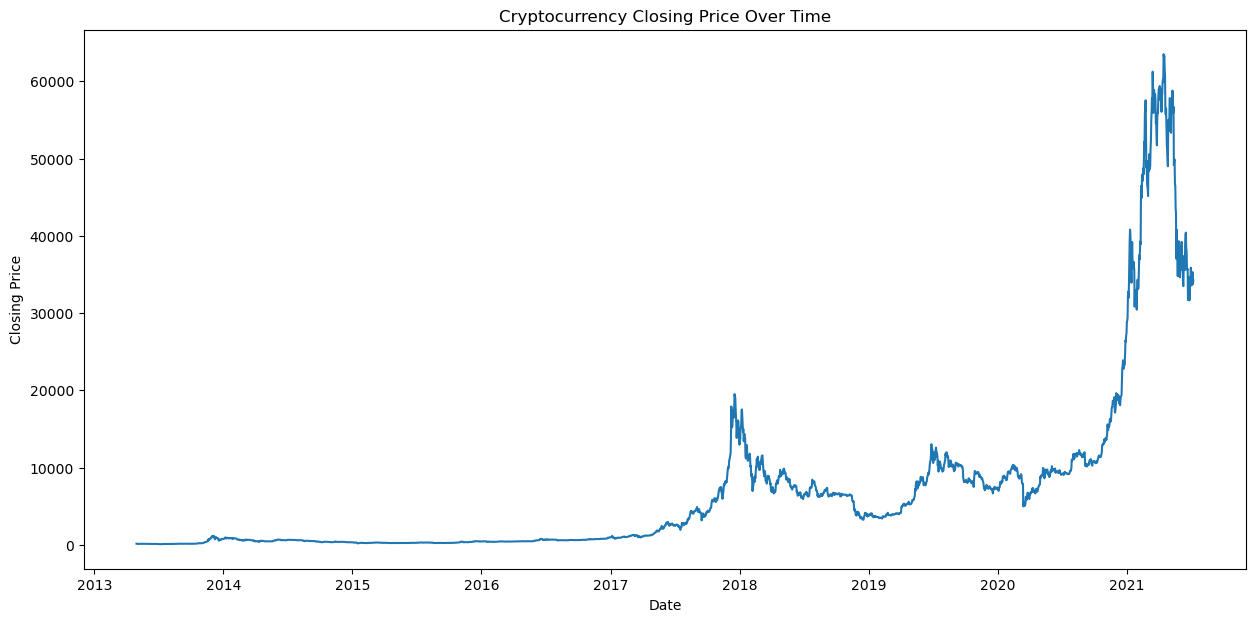

In [75]:
plt.figure(figsize=(15,7))
plt.plot(data['Close'])
plt.title('Cryptocurrency Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

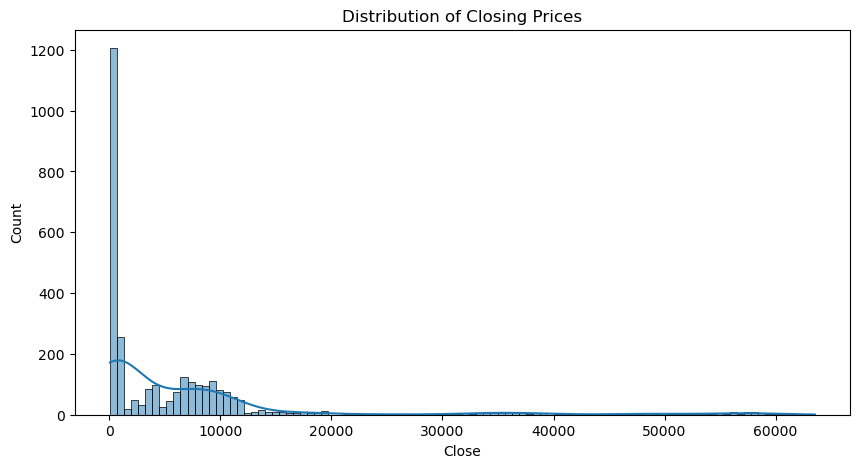

In [76]:
plt.figure(figsize=(10,5))
sns.histplot(data['Close'], bins=100, kde=True)
plt.title('Distribution of Closing Prices')
plt.show()

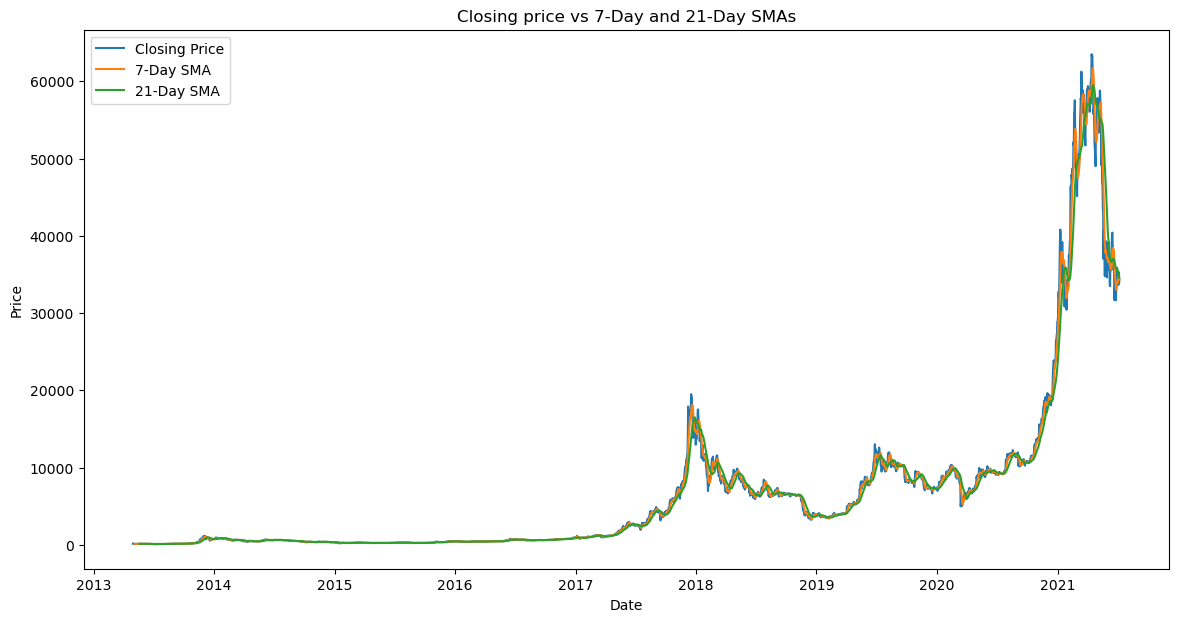

In [77]:
data['SMA_7'] = data['Close'].rolling(window=7).mean()
data['SMA_21'] = data['Close'].rolling(window=21).mean()

plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='Closing Price')
plt.plot(data['SMA_7'], label='7-Day SMA')
plt.plot(data['SMA_21'], label='21-Day SMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Closing price vs 7-Day and 21-Day SMAs')
plt.legend()
plt.show()

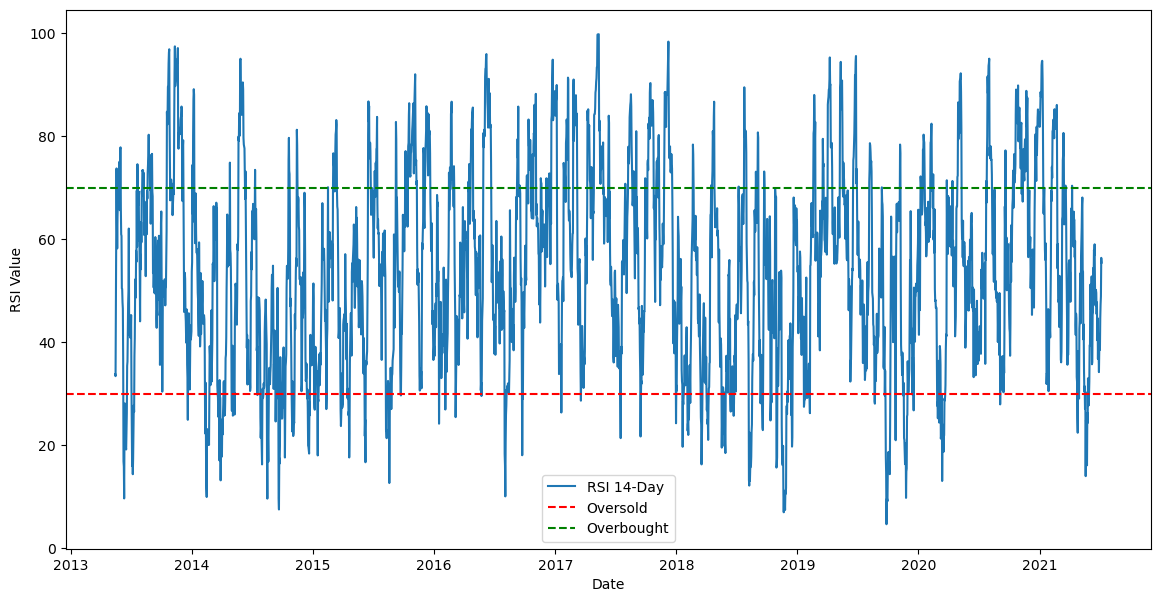

In [78]:
def calculate_RSI(series, period=14):
    delta = series.diff(1)
    delta = delta.dropna()
    up = delta.copy()
    down = delta.copy()
    up[up<0] = 0
    down[down>0] = 0
    gain = up.rolling(window=period).mean()
    loss = down.abs().rolling(window=period).mean()
    RS = gain / loss
    RSI = 100 - (100.0 / (1.0 + RS))
    return RSI
data['RSI_14'] = calculate_RSI(data['Close'])

plt.figure(figsize=(14,7))
plt.plot(data['RSI_14'], label='RSI 14-Day')
plt.axhline(30, color='red', linestyle='--', label='Oversold')
plt.axhline(70, color='green', linestyle='--', label='Overbought')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.show()

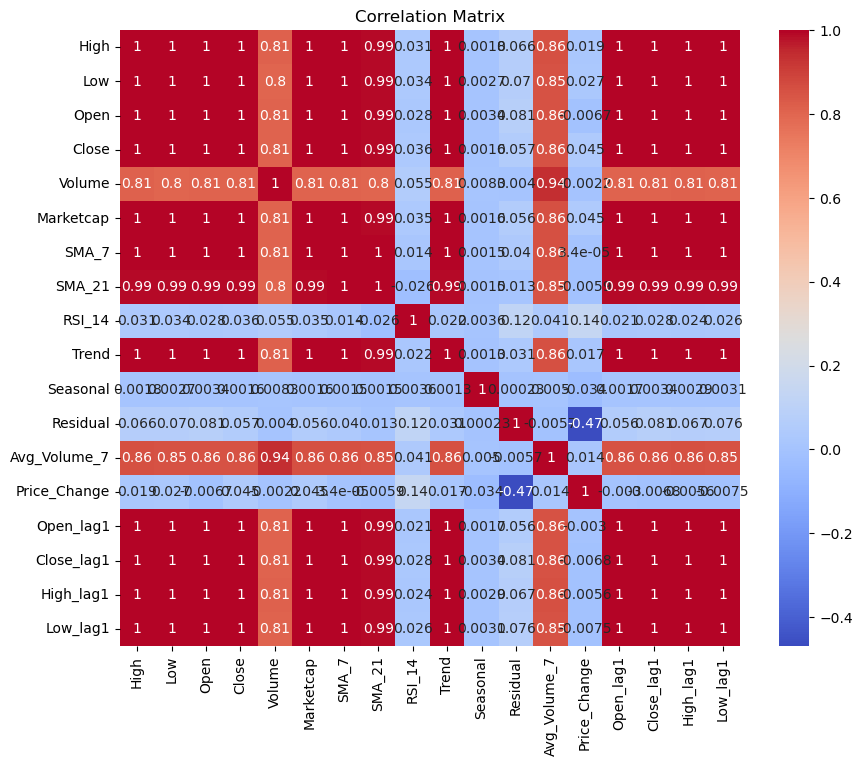

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

decomposition = seasonal_decompose(data['Open'], model='additive', period=12)
data['Trend'] = decomposition.trend
data['Seasonal'] = decomposition.seasonal
data['Residual'] = decomposition.resid
data['Avg_Volume_7'] = data['Volume'].rolling(window=7).mean()
data['Price_Change'] = data['Close'].diff()
data['Open_lag1'] = data['Open'].shift(1)
data['Close_lag1'] = data['Close'].shift(1)
data['High_lag1'] = data['High'].shift(1)
data['Low_lag1'] = data['Low'].shift(1)

data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
data = data.drop(['Name', 'SNo', 'Symbol'], axis=1)
data = data.dropna()
corr_matrix = data.drop(['Target'], axis=1).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [82]:
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2965 entries, 2013-05-19 23:59:59 to 2021-06-30 23:59:59
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   High          2965 non-null   float64
 1   Low           2965 non-null   float64
 2   Open          2965 non-null   float64
 3   Close         2965 non-null   float64
 4   Volume        2965 non-null   float64
 5   Marketcap     2965 non-null   float64
 6   SMA_7         2965 non-null   float64
 7   SMA_21        2965 non-null   float64
 8   RSI_14        2965 non-null   float64
 9   Trend         2965 non-null   float64
 10  Seasonal      2965 non-null   float64
 11  Residual      2965 non-null   float64
 12  Avg_Volume_7  2965 non-null   float64
 13  Price_Change  2965 non-null   float64
 14  Open_lag1     2965 non-null   float64
 15  Close_lag1    2965 non-null   float64
 16  High_lag1     2965 non-null   float64
 17  Low_lag1      2965 non-null   float

In [83]:
data.dtypes

High            float64
Low             float64
Open            float64
Close           float64
Volume          float64
Marketcap       float64
SMA_7           float64
SMA_21          float64
RSI_14          float64
Trend           float64
Seasonal        float64
Residual        float64
Avg_Volume_7    float64
Price_Change    float64
Open_lag1       float64
Close_lag1      float64
High_lag1       float64
Low_lag1        float64
Target            int32
dtype: object

In [84]:
data.index = pd.to_datetime(data.index)
cutoff_date = '2020-01-01'

train_data = data[data.index < cutoff_date]
test_data = data[data.index >= cutoff_date]

In [88]:
features = data.drop(['Target'], axis=1).columns.tolist()
X_train = train_data[features]
y_train = train_data['Target']

X_test = test_data[features]
y_test = test_data['Target']

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

In [89]:
from sklearn.ensemble import RandomForestClassifier